# System Overview

[![Click and Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/metadriverse/metaurban/blob/main/documentation/source/new_env.ipynb)

This section will walk through how we build new environments or simulations from scratch.
Let's get familiar with the project first

## Project Structure

The project structure is as follows:
- **documentation**:  It contains files building this documentation
- **metaurban**:  the metaurban package, most content is in this directory

The `metaurban` package has the following structure:
- **assets**:  it is downloaded from github releases automatically, containing models, textures, and mini-batch real-world scenarios
- **assets_pedestrain**:  it is downloaded from github releases automatically, containing 3D assets of pedestrians
- **base_class**:  meta-classes for making other python classes, usually you don't need to modify it
- **component**:  objects/vehicles/maps/lanes/building, almost all elements used for constructing scenario is here
- **engine**:  it contains code regarding the simulation loop, top-down renderer, asset manager/loader, physics system, logger, skybox, shadow, and so on
- **envs**:  a collection of gym-style environments
- **examples**:  runnable scripts for making yourself familiar with MetaUrban
- **manager**:  managers that defines how to create/forward scene are stored here
- **obs**:  a collection of observations that define how to collect information from the simulator in each step
- **policy**:  a collection of policies that define how an object should act in each step
- **render_pipeline**:  it contains the deferred rendering pipeline, which is developed by [tobspr](https://github.com/tobspr/RenderPipeline)
- **scenario**:  it defines the universal scenario format and a set of tools to read data from the format, like parsing object state
- **shaders**:  .glsl shaders for making skybox, terrain, depth camera and so on
- **tests**:  unitest are located here, which can be viewed as examples as well
- **third_party**:  libraries developed by others
- **utils**:  various tool functions
- **constants.py**:  it defines constants and some properties used everywhere
- **type.py**:  all objects have a type label, which is selected from here
- **pull_asset**:  scripts to pull or update asset from the remote git release page

## Start point-BaseEnv
To start making your own environment, the first step is to have something runnable so you can build things on top of it.
This can be done with `BaseEnv`, which is an empty environment with only a vehicle placed in this environment.
So just make a new `your_env.py` file and put the following code into it.
**Note: we usually use 3D renderer to do development as it shows more details, but using 2D visualizer is allowed as well. In this doc, we use 2D renderer for convinience.** 
If you have a screen with OpenGL support, you can completely remove the `env.render` and `env.top_down_renderer.generate_gif`. If OpenGL is not supported on your machine but a screen is still available, just turn off the `screen_record` and set `window=True` for top_down_renderer and remove `env.top_down_renderer.generate_gif`. Otherwise, just keep everying unchanged. Without a screen, the only way to visualize the environment is through generating GIFs.

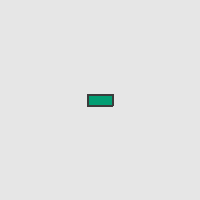

In [2]:
from metaurban.envs.base_env import BaseEnv
from metaurban.obs.observation_base import DummyObservation
import logging

class MyEnv(BaseEnv):

    def reward_function(self, agent):
        return 0, {}

    def cost_function(self, agent):
        return 0, {}

    def done_function(self, agent):
        return False, {}
    
    def get_single_observation(self):
        return DummyObservation()
        

if __name__=="__main__":
    # create env
    env=MyEnv(dict(use_render=False, # if you have a screen and OpenGL suppor, you can set use_render=True to use 3D rendering  
                   manual_control=True, # we usually manually control the car to test environment
                   log_level=logging.CRITICAL)) # suppress logging message
    env.reset()
    for i in range(20):
        
        # step
        obs, reward, termination, truncate, info = env.step(env.action_space.sample())
        
        # you can set window=True and remove generate_gif() if you have a screen. 
        # Or just use 3D rendering and remove all stuff related to env.render()  
        frame=env.render(mode="topdown", 
                         window=False, # turn me on, if you have screen
                         screen_record=True, # turn me off, if a window can be poped up
                         screen_size=(200, 200))
    env.top_down_renderer.generate_gif()
    env.close()

from IPython.display import Image
Image(open("demo.gif", 'rb').read())

As shown in the figure above, this environment contains nothing. We will make it complete gradually.
Firstly, let's add a map to the environment to make it a bit interesting.
**Also, when we develop a new environment, developing map and map management module is the first step we do. This is because map is the most important component associated with a lot of things like observation and navigation. Thus, the map has to be created in a scene firstly and the map management module `map_manager` should have the highest priority.**

## MapManager
Compared to the last code cell, we add a map manager to generate different maps for each seed. Concretely, there are three maps and we choose from the three maps according to the global seed by `map_id = global_seed % 3`. New content added upon the last code cell are marked between two `======`. 

Load map with shape: X
Load map with shape: T
Load map with shape: O
Load map with shape: X


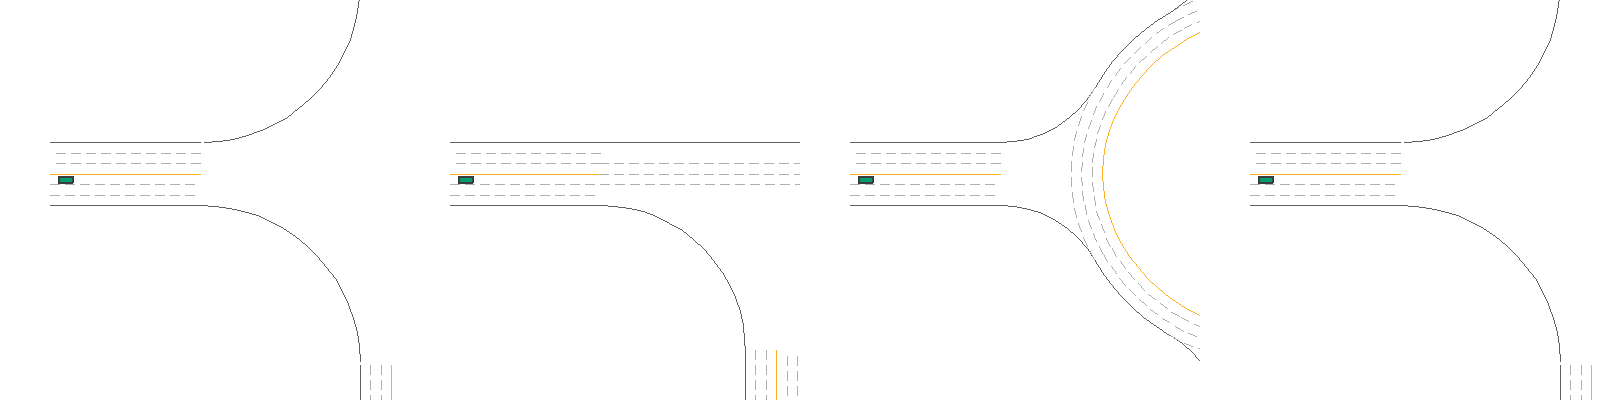

In [1]:
from metaurban.envs.base_env import BaseEnv
from metaurban.obs.observation_base import DummyObservation
import logging

# ======================================== new content ===============================================
import cv2
from metaurban.component.map.pg_map import PGMap
from metaurban.manager.base_manager import BaseManager
from metaurban.component.pgblock.first_block import FirstPGBlock

class MyMapManager(BaseManager):
    PRIORITY = 0

    def __init__(self):
        super(MyMapManager, self).__init__()
        self.current_map = None
        self.all_maps = {idx: None for idx in range(3)} # store the created map
        self._map_shape = ["X", "T", "O"] # three types of maps 

    def reset(self):
        idx = self.engine.global_random_seed % 3
        if self.all_maps[idx] is None:
            # create maps on the fly
            new_map = PGMap(map_config=dict(type=PGMap.BLOCK_SEQUENCE,
                                            config=self._map_shape[idx]))
            self.all_maps[idx] = new_map

        # attach map in the world
        map = self.all_maps[idx]
        map.attach_to_world()
        self.current_map = map
        return dict(current_map=self._map_shape[idx])

    def before_reset(self):
        if self.current_map is not None:
            self.current_map.detach_from_world()
            self.current_map = None

    def destroy(self):
        # clear all maps when this manager is destroyed
        super(MyMapManager, self).destroy()
        for map in self.all_maps.values():
            if map is not None:
                map.destroy()
        self.all_maps = None


# Expand the default config system, specify where to spawn the car
MY_CONFIG = dict(agent_configs={"default_agent": dict(spawn_lane_index=(FirstPGBlock.NODE_1, FirstPGBlock.NODE_2, 0))}) 


class MyEnv(BaseEnv):
    
    @classmethod
    def default_config(cls):
        config = super(MyEnv, cls).default_config()
        config.update(MY_CONFIG)
        return config
    
    def setup_engine(self):
        super(MyEnv, self).setup_engine()
        self.engine.register_manager("map_manager", MyMapManager())
        
# ======================================== new content ===============================================

    def reward_function(self, agent):
        return 0, {}

    def cost_function(self, agent):
        return 0, {}

    def done_function(self, agent):
        return False, {}
    
    def get_single_observation(self):
        return DummyObservation()
        

if __name__=="__main__":
    frames = []
    
    # create env
    env=MyEnv(dict(crswalk_density=1.,
                   use_render=False, # if you have a screen and OpenGL suppor, you can set use_render=True to use 3D rendering  
                   manual_control=True, # we usually manually control the car to test environment
                   num_scenarios=4,
                   log_level=logging.CRITICAL)) # suppress logging message
    for i in range(4):
        
        # reset
        o, info = env.reset(seed=i)
        print("Load map with shape: {}".format(info["current_map"]))
        # you can set window=True and remove generate_gif() if you have a screen. 
        # Or just use 3D rendering and remove all stuff related to env.render()  
        frame=env.render(mode="topdown", 
                         window=False, # turn me on, if you have screen
                         scaling=3,
                         camera_position=(50, 0),
                         screen_size=(400, 400))
        frames.append(frame)
    cv2.imwrite("demo.png",  cv2.cvtColor(cv2.hconcat(frames), cv2.COLOR_RGB2BGR))
    env.close()

from IPython.display import Image
Image(open("demo.png", 'rb').read())

The results show 4 scenarios and the 4th scenario is the same as the first one, as we repeatedly load the 3 maps according to `MyMapManager.reset()`.
This function also returns the shape of the current map, which you can access in the `info` returned by `env.step()`.
**Thus, in your own development, you can collect simulation information and return them by `env.step()` by returning a dictionary in these functions: `before_step`, `step`, `after_step`, `before_reset`, `reset`, `after_reset`.**
Another thing to take care of is that we overwrite the original `agent_configs` of `BaseEnv`.
It defines where to spawn the agent with the id `default_agent`.
You can create maps automatically with `PGMap` which combines some predefined blocks.

## AssetManager
Compared to the last code cell, we add a asset manager to generate different objects on sidewalk for each seed. New content added upon the last code cell are marked between two `======`. 

[INFO] Environment: MyEnv
[INFO] MetaUrban version: 0.0.1
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[WARNING] You are using DummyObservation which doesn't collect information from the environment. (observation_base.py:50)
[INFO] Assets version: 0.0.1
[INFO] Known Pipes: glxGraphicsPipe
[WARNING] Can not find `start_seed` or `start_scenario_index`. Use 0 as `start_seed` (base_engine.py:577)
[INFO] Start Scenario Index: 0, Num Scenarios : 4
[WARNING] Can not find `start_seed` or `start_scenario_index`. Use 0 as `start_seed` (base_engine.py:577)
[WARNING] Can not find `start_seed` or `start_scenario_index`. Use 0 as `start_seed` (base_engine.py:577)
[WARNING] Can not find `start_seed` or `start_scenario_index`. Use 0 as `start_seed` (base_engine.py:577)
[WARNING] Can not find `start_seed` or `start_scenario_index`. Use 0 as `start_seed` (base_engine.py:577)


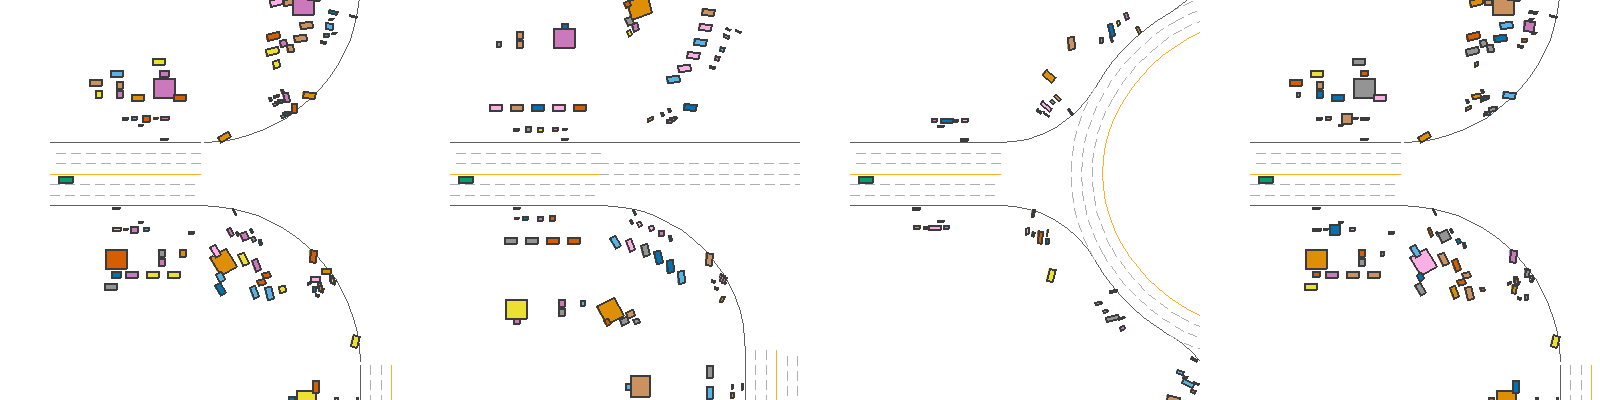

In [2]:
from metaurban.envs.base_env import BaseEnv
from metaurban.obs.observation_base import DummyObservation
import logging

# ======================================== new content ===============================================
import cv2
from metaurban.manager.sidewalk_manager import AssetManager

class MyAssetManager(AssetManager):
    PRIORITY = 9

    def __init__(self):
        super(MyAssetManager, self).__init__()


    def reset(self):
        super(MyAssetManager, self).reset()

# Expand the default config system, specify where to spawn the car
MY_CONFIG = dict(agent_configs={"default_agent": dict(spawn_lane_index=(FirstPGBlock.NODE_1, FirstPGBlock.NODE_2, 0))}, object_density=0.3) 

class MyEnv(BaseEnv):
    
    @classmethod
    def default_config(cls):
        config = super(MyEnv, cls).default_config()
        config.update(MY_CONFIG)
        return config
    
    def setup_engine(self):
        super(MyEnv, self).setup_engine()
        self.engine.register_manager("map_manager", MyMapManager())
        self.engine.register_manager("asset_manager", MyAssetManager())
        
# ======================================== new content ===============================================

    def reward_function(self, agent):
        return 0, {}

    def cost_function(self, agent):
        return 0, {}

    def done_function(self, agent):
        return False, {}
    
    def get_single_observation(self):
        return DummyObservation()
        

if __name__=="__main__":
    frames = []
    
    # create env
    env=MyEnv(dict(crswalk_density=1.,
                   use_render=False, # if you have a screen and OpenGL suppor, you can set use_render=True to use 3D rendering  
                   manual_control=True, # we usually manually control the car to test environment
                   num_scenarios=4)) # suppress logging message
    for i in range(4):
        
        # reset
        o, info = env.reset(seed=i)
        # you can set window=True and remove generate_gif() if you have a screen. 
        # Or just use 3D rendering and remove all stuff related to env.render()  
        frame=env.render(mode="topdown", 
                         window=False, # turn me on, if you have screen
                         scaling=3,
                         camera_position=(50, 0),
                         screen_size=(400, 400))
        frames.append(frame)
    cv2.imwrite("demo.png",  cv2.cvtColor(cv2.hconcat(frames), cv2.COLOR_RGB2BGR))
    env.close()

from IPython.display import Image
Image(open("demo.png", 'rb').read())